In [2]:
#pip install matplotlib pandas geopandas scikit-learn

In [3]:
#BIBLIOTHEQUES
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import sqlite3
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

In [4]:
# ===================================================
# Chargement de la data finale
# ===================================================
# Ici, nous chargeons notre GeoDataFrame finale depuis un fichier GeoPackage.
# Ce fichier contient toutes les informations mensuelles et par commune
gpkg_path = "C:/Users/Hp Elitebook/Desktop/python/df_erreur.gpkg" 
layer_name = None  
gdf = gpd.read_file(gpkg_path, layer=layer_name)
#Affciher le head de la data
gdf.head()

,SWI_UNIF_MENS,ym,swi_min,swi_mean,swi_max,prenei_sum,preliq_sum,pe_sum,evap_sum,t_avg,...,code_insee_canton,code_insee_des_arrondissements,code_insee_du_departement,code_insee_de_la_region,surface,dept_name,region_name,year,sq_error_rf,geometry
0,0.950,2020-01,0.851,0.894806,0.950,0.0,48.2,27.0,21.2,7.200000,...,5996,599,59,32,4390.0,Nord,Hauts-de-France,2020,0.000279,POINT (657366 7106175)
1,0.949,2020-01,0.861,0.902290,0.956,0.0,48.2,29.5,18.7,7.225806,...,5917,591,59,32,3590.0,Nord,Hauts-de-France,2020,0.000170,POINT (665362 7106108)
2,0.957,2020-01,0.858,0.904290,0.956,0.0,45.3,24.5,20.8,7.319355,...,6234,623,62,32,3160.0,Pas-de-Calais,Hauts-de-France,2020,0.000407,POINT (625315 7098447)
3,0.957,2020-01,0.857,0.904000,0.956,0.0,45.3,24.8,20.5,7.319355,...,6234,623,62,32,3390.0,Pas-de-Calais,Hauts-de-France,2020,0.000347,POINT (633311 7098380)
4,0.949,2020-01,0.859,0.897968,0.948,0.0,48.2,27.4,20.8,7.212903,...,5920,592,59,32,810.0,Nord,Hauts-de-France,2020,0.000210,POINT (641307 7098313)


In [5]:
# Nombre de communes uniques par année
communes_per_year = gdf.groupby('year')['code_insee'].nunique().reset_index()
communes_per_year.rename(columns={'code_insee': 'n_communes'}, inplace=True)

print(communes_per_year)


   year  n_communes
0  2020        8046
1  2021        8046
2  2022        8046
3  2023        8046
4  2024        8046


In [6]:
# ===================================================
# Nettoyage avant l'agrégation
# ===================================================
# On supprime toutes les colonnes mensuelles et redondantes qui ne seront
# pas utilisées pour l'agrégation annuelle. Cela simplifie le dataframe
cols_to_drop = [
    'ym',
    'swi_min', 'swi_mean', 'swi_max',
    'prenei_sum', 'preliq_sum', 'pe_sum', 'evap_sum',
    't_avg', 'ff_avg', 'q_avg', 'hu_avg', 'dli_avg',
    'ssi_avg', 'etp_avg', 'tinf_avg', 'tsup_avg',
    'resr_neige_avg', 'resr_neige6_avg',
    'hteurneige_avg', 'hteurneige6_avg', 'hteurneigex_avg',
    'snow_frac_avg',
    'drainc_sum', 'runc_sum', 'ecoulement_sum',
    'wg_racine_avg', 'wgi_racine_avg',
    'NIVEAU',
    'index__adm',"geometry","cleabs","surface","population", 'code_insee_du_departement', 'code_insee_de_la_region'
]

# Suppression sécurisée
gdf = gdf.drop(columns=[c for c in cols_to_drop if c in gdf.columns])
alea_map = {
    'Faible': 1,
    'Moyen': 2,
    'Fort': 3
}

gdf['ALEA_num'] = gdf['ALEA'].map(alea_map)



##### Agregation annuelle

In [7]:
# ===================================================
# Agrégation annuelle par commune
# ===================================================
# L'objectif est de passer d'une data mensuelle à une data annuelle,
# avec une ligne par (commune, année).

agg_dict = {
    'SWI_UNIF_MENS': 'min',
    'ALEA_num': 'max', 
    'sq_error_rf': 'max',

    'nom_commune': 'first',
    'code_insee_canton': 'first',
    'code_insee_des_arrondissements': 'first',
    'dept_name': 'first',
    'region_name': 'first',
}

gdf_annual = (
    gdf
    .groupby(['code_insee', 'year'], as_index=False)
    .agg(agg_dict)
)

# Vérifications
print("Shape :", gdf_annual.shape)


Shape : (40230, 10)


In [8]:
gdf_annual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40230 entries, 0 to 40229
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   code_insee                      40230 non-null  object 
 1   year                            40230 non-null  int32  
 2   SWI_UNIF_MENS                   40230 non-null  float64
 3   ALEA_num                        29750 non-null  float64
 4   sq_error_rf                     40230 non-null  float64
 5   nom_commune                     40230 non-null  object 
 6   code_insee_canton               40230 non-null  object 
 7   code_insee_des_arrondissements  40230 non-null  object 
 8   dept_name                       40230 non-null  object 
 9   region_name                     40230 non-null  object 
dtypes: float64(3), int32(1), object(6)
memory usage: 2.9+ MB


In [9]:
# code_insee est actuellement en object => le convertir en int64
gdf_annual["code_insee"] = gdf_annual["code_insee"].astype("string")
# year, le convertir en int64
gdf_annual["year"] = gdf_annual["year"].astype("int64")

### Résumé : Chargement et agrégation annuelle des données
- **Objectif** : Passer d'une data mensuelle par commune à une data annuelle consolidée, prête pour l'analyse et la modélisation.
- **Étapes réalisées** :
  1. **Chargement de la data finale** depuis un GeoPackage (`df_erreur.gpkg`) contenant toutes les informations mensuelles par commune.
  2. **Vérification de la couverture des communes** par année pour s'assurer que toutes les communes attendues sont présentes.
  3. **Nettoyage des colonnes** : suppression des colonnes mensuelles et des variables inutiles pour l'agrégation annuelle.
  4. **Conversion des variables catégorielles en numériques** : notamment la variable `ALEA` en `ALEA_num` pour représenter le niveau de risque.
  5. **Agrégation annuelle par commune** 
  6. **Vérifications finales** : contrôle de la dimension du dataframe et des types de colonnes pour s'assurer que les données sont prêtes pour les étapes suivantes.


### Data catnat commune et année

In [10]:
# ===================================================
# Lecture et concaténation des CSV annuels
# ===================================================
# - on renomme les colonnes utiles
# - on ne garde que les colonnes nécessaires (Insee, debut_event, decision)
# - on convertit les types pour pouvoir les utiliser dans SQL ou pandas
# --- 1. Connexion SQLite ---
db_path = r'C:\Users\Hp Elitebook\Desktop\python\catnat.db'
conn = sqlite3.connect(db_path)
print(f"Connexion à {db_path} établie.")

# Nettoyage éventuel
conn.execute("DROP TABLE IF EXISTS catnat_temp")
conn.execute("DROP TABLE IF EXISTS catnat_annual")

# --- 2. Parcourir tous les dossiers annuels et concaténer les CSV ---
for year in range(2020, 2026):
    folder = Path(rf'C:\Users\Hp Elitebook\Desktop\python\catnat_{year}')

    for csv_file in folder.glob('*.csv'):
        df = pd.read_csv(csv_file, sep=';', encoding='utf-8')

        # Renommage des colonnes utiles uniquement
        df = df.rename(columns={
            'N° Insee': 'Insee',
            'Début d\'Événement': 'debut_event',
            'Décision': 'decision'
        })

        # Sélection stricte des colonnes nécessaires
        df = df[['Insee', 'debut_event', 'decision']]

        # Types
        df['Insee'] = pd.to_numeric(df['Insee'], errors='coerce').astype('Int64')
        df['debut_event'] = pd.to_datetime(df['debut_event'], errors='coerce', dayfirst=True)

        # Suppression des lignes invalides
        df = df.dropna(subset=['Insee', 'debut_event'])

        # Écriture temporaire
        df.to_sql('catnat_temp', conn, if_exists='append', index=False)

print("✔ Tous les CSV ont été concaténés dans catnat_temp")

# --- 3. Création de la variable year + table annuelle finale ---
query = """
CREATE TABLE catnat_annual AS
SELECT
    CAST(Insee AS VARCHAR(10)) AS Insee,
    CAST(strftime('%Y', debut_event) AS INTEGER) AS year,
    decision
FROM catnat_temp
"""

conn.execute(query)
conn.commit()

print("✔ Table catnat_annual créée")

# --- 4. Vérification ---
catnat_annual = pd.read_sql("SELECT * FROM catnat_annual", conn)
print(catnat_annual.head())


Connexion à C:\Users\Hp Elitebook\Desktop\python\catnat.db établie.
✔ Tous les CSV ont été concaténés dans catnat_temp
✔ Table catnat_annual créée
  Insee  year      decision
0  2377  2018      Reconnue
1  2518  2018      Reconnue
2  6130  2018  Non reconnue
3  7338  2018      Reconnue
4  8454  2018      Reconnue


In [11]:
# Harmonisation du type et du nom de la clé pour la jointure avec notre GeoDataFrame
catnat_annual["Insee"] = catnat_annual["Insee"].astype("string")
catnat_annual = catnat_annual.rename(columns={"Insee": "code_insee"})

# Création de la variable binaire 'secheresse' :
# 1 si la décision est "Reconnue", 0 sinon
catnat_annual["secheresse"] = (catnat_annual["decision"] == "Reconnue").astype(int)

#### Résumé : Traitement des données CatNat

1. **Lecture et concaténation** des fichiers CSV annuels CatNat (2020‑2025) dans SQLite.  
2. **Sélection des colonnes essentielles** : `Insee`, `Début d'Événement`, `Décision`.  
3. **Conversion des types** : `Insee` → entier, `Début d'Événement` → datetime, suppression des lignes invalides.  
4. **Création de la table annuelle** : extraction de l'année depuis `Début d'Événement` et conservation de la décision.  
5. **Préparation pour jointure** : renommage `Insee` → `code_insee` et création de la variable binaire `secheresse` (1 si "Reconnue", 0 sinon).  


### Jointure

In [12]:
#JOINTURE GeoDataFrame annuel avec la table CatNat annuelle
gdf_final = gdf_annual.merge(
    catnat_annual,
    on=["code_insee", "year"],
    how="left"      # ou "left"/"outer" selon ton besoin
)


gdf_final['decision'] = gdf_final['decision'].fillna('Non reconnue')
gdf_final['secheresse'] = gdf_final['secheresse'].fillna(0).astype(int)

gdf_final.head()

,code_insee,year,SWI_UNIF_MENS,ALEA_num,sq_error_rf,nom_commune,code_insee_canton,code_insee_des_arrondissements,dept_name,region_name,decision,secheresse
0,01006,2020,0.122,1.0,0.000807,Ambléon,0104,010,Ain,Auvergne-Rhône-Alpes,Non reconnue,0
1,01006,2021,0.492,1.0,0.000225,Ambléon,0104,010,Ain,Auvergne-Rhône-Alpes,Non reconnue,0
2,01006,2022,0.091,1.0,0.000326,Ambléon,0104,010,Ain,Auvergne-Rhône-Alpes,Non reconnue,0
3,01006,2023,0.145,1.0,0.000386,Ambléon,0104,010,Ain,Auvergne-Rhône-Alpes,Non reconnue,0
4,01006,2024,0.278,1.0,0.000286,Ambléon,0104,010,Ain,Auvergne-Rhône-Alpes,Non reconnue,0


In [13]:
gdf_final["secheresse"].value_counts(normalize=True)


secheresse
0    0.937612
1    0.062388
Name: proportion, dtype: float64

Dans notre base finale, la variable cible `secheresse` est fortement déséquilibrée : environ **93,8 %** des communes/années ne sont pas reconnues au titre de CatNat pour sécheresse (`0`), tandis que seulement **6,2 %** le sont (`1`). Ce déséquilibre indique que la majorité des communes ne subissent pas de reconnaissance officielle, ce qui peut compliquer la modélisation si aucune précaution n'est prise


### XGBoost

In [14]:
# -------------------------------
# 1️⃣ Sélection des features
# -------------------------------
categorical_features = ['dept_name', 'region_name','ALEA_num', 'year']  # one-hot
numeric_features = ['SWI_UNIF_MENS', 'sq_error_rf']  # numériques

# Copier la base pour travailler proprement
df_model = gdf_final.copy()

X = df_model[categorical_features + numeric_features]
y = df_model['secheresse']

# -------------------------------
# 2️⃣ Split temporel
# -------------------------------
train_mask = df_model['year'].isin([2020, 2021, 2022])
test_mask  = df_model['year'].isin([2023, 2024])

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test   = X[test_mask], y[test_mask]

# -------------------------------
# 3️⃣ Transformer
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

# -------------------------------
# 4️⃣ Modèle XGBoost
# -------------------------------
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Pipeline complet
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', xgb_model)
])

# -------------------------------
# 5️⃣ Entraînement
# -------------------------------
xgb_pipeline.fit(X_train, y_train)
# -------------------------------
# 8️⃣ Extraire y_proba uniquement pour 2023
# -------------------------------
X_test_2023 = X_test[X_test['year'] == 2023].copy()
y_proba_2023 = xgb_pipeline.predict_proba(X_test_2023)[:,1]

# Prédiction
y_pred = xgb_pipeline.predict(X_test)
y_proba = xgb_pipeline.predict_proba(X_test)[:,1]

# 7️⃣ Calcul AUC et rapport
# -------------------------------
auc = roc_auc_score(y_test, y_proba)
print(f"AUC ROC : {auc:.3f}")
print(classification_report(y_test, y_pred))


AUC ROC : 0.935
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15795
           1       0.33      0.00      0.01       311

    accuracy                           0.98     16106
   macro avg       0.66      0.50      0.50     16106
weighted avg       0.97      0.98      0.97     16106



Le modèle entraîné sur la période **2020–2022** et évalué sur **2023–2024** présente une **AUC-ROC élevée (0,935)**, indiquant une très bonne capacité globale à discriminer les situations de sécheresse reconnue des situations non reconnues. Autrement dit, le modèle attribue en moyenne des probabilités plus élevées aux communes effectivement reconnues. Néanmoins, l’analyse des métriques de classification met en évidence une **forte dissymétrie entre les classes**. La classe majoritaire (absence de reconnaissance) est prédite avec une performance quasi parfaite, tandis que la classe minoritaire (`secheresse = 1`) présente un **rappel extrêmement faible**, traduisant une difficulté du modèle à identifier les événements de sécheresse reconnus. Ce comportement est directement lié au **déséquilibre marqué de la variable cible**, les reconnaissances représentant une faible proportion des observations.

Dans ce contexte, l’accuracy élevée (98 %) est peu informative et doit être interprétée avec prudence. Il devient alors essentiel de **s’intéresser à la distribution des probabilités prédites (`y_proba`) sur l’échantillon de test**, plutôt qu’aux prédictions binaires seules. L’analyse des probabilités permet d’évaluer si le modèle identifie correctement des situations à risque, même lorsque le seuil de classification standard (0,5) conduit à peu de prédictions positives.

Par ailleurs, la **faible occurrence de sinistres reconnus en 2024** limite la pertinence d’une analyse spatiale ou statistique robuste sur cette année. En conséquence, la représentation cartographique et l’interprétation des probabilités de sécheresse se concentrent principalement sur **l’année 2023**, qui constitue une période plus informative pour évaluer le comportement spatial et probabiliste du modèle. Ainsi, l’étude des cartes de probabilités pour 2023 permet non seulement de mieux comprendre la logique du modèle, mais aussi d’identifier des territoires présentant un **risque latent de sécheresse** non nécessairement reconnu, ouvrant la voie à une approche plus prospective que strictement rétrospective.


### Carte de probabilité pour 2023

In [15]:
import geopandas as gpd

communes_gdf = gpd.read_file(r"C:\Users\Hp Elitebook\Desktop\python\ADE.gpkg")
# -------------------------------------------------
gdf_test = gdf_final[gdf_final['year'].isin([2023, 2024])].copy()
gdf_2023 = gdf_test[gdf_test['year'] == 2023].copy()


gdf_2023['proba_secheresse'] = y_proba_2023  


In [16]:
import matplotlib.pyplot as plt
import folium

# -------------------------------------------------
# 2️⃣ S'assurer que le code_insee est bien au même format
# -------------------------------------------------
communes_gdf['codgeo'] = communes_gdf['codgeo'].astype(str).str.zfill(5)
gdf_2023['code_insee'] = gdf_2023['code_insee'].astype(str).str.zfill(5)
communes_gdf = communes_gdf.rename(columns={'codgeo': 'code_insee'})
# -------------------------------------------------
# 3️⃣ Merge probabilités avec la géométrie
# -------------------------------------------------
gdf_map_2023 = communes_gdf.merge(
    gdf_2023[['code_insee', 'proba_secheresse']],
    on='code_insee',
    how='left'
)

# Vérification
print(gdf_map_2023[['code_insee', 'proba_secheresse']].head())


  code_insee  proba_secheresse
0      01001               NaN
1      01002               NaN
2      01004               NaN
3      01005               NaN
4      01006           0.00061


In [17]:
communes_gdf.columns

Index(['code_insee', 'libgeo', 'population', 'can', 'dept', 'reg', 'superf',
       'geometry'],
      dtype='object')

In [21]:
gdf_final.columns

Index(['code_insee', 'year', 'SWI_UNIF_MENS', 'ALEA_num', 'sq_error_rf',
       'nom_commune', 'code_insee_canton', 'code_insee_des_arrondissements',
       'dept_name', 'region_name', 'decision', 'secheresse'],
      dtype='object')

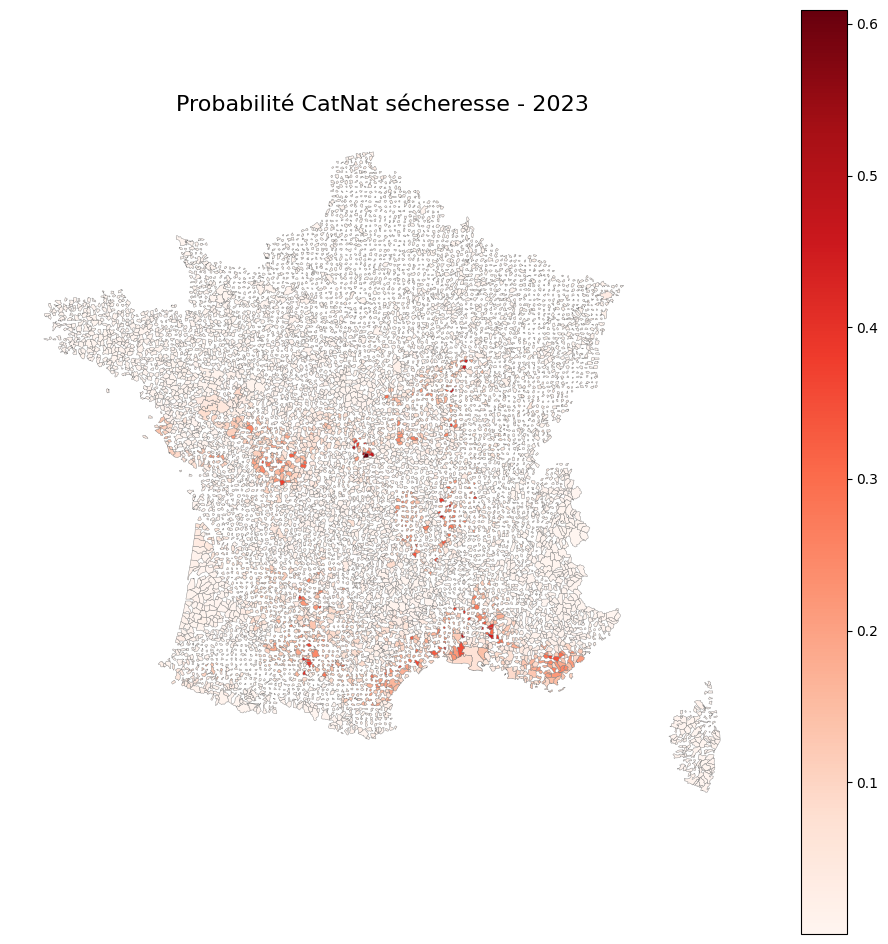

In [18]:
# -------------------------------------------------
# Carte statique avec GeoPandas + Matplotlib
# -------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_map_2023.plot(
    column='proba_secheresse',
    cmap='Reds',
    linewidth=0.3,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title("Probabilité CatNat sécheresse - 2023", fontsize=16)
ax.axis('off')
plt.show()


Compléter la lecture de la carte
Les teintes de rouge représentent uniquement les communes présentes dans la base de modélisation, soit environ 8 000 communes sur près de 35 000 communes métropolitaines, ce qui signifie qu’une grande partie du territoire apparaît en “blanc” non pas parce que la probabilité est nulle, mais parce qu’elle n’a pas été estimée.
​

La carte doit donc être lue comme une projection des décisions CatNat sur un sous‑ensemble de communes observées, avec des probabilités non nulles uniquement là où l’historique de données (SWI, sols, demandes CatNat, etc.) permettait d’entraîner le modèle.

Ce que cela implique pour le processus CatNat
Le fait que seules 8 000 communes disposent d’une probabilité modélisée traduit aussi une forme de sélection institutionnelle : ce sont majoritairement des communes qui ont déjà un historique de demandes et de décisions CatNat sécheresse, ce qui reflète un processus où toutes les communes théoriquement exposées ne se retrouvent pas dans le circuit administratif.
​

Les zones blanches ne sont donc pas des zones “sans risque”, mais des zones hors champ du modèle, souvent des communes petites ou peu actives administrativement, ce qui illustre bien que le régime CatNat couvre de manière inégale l’ensemble des quelque 35 000 communes françaises.
​

Lien renforcé avec les objectifs de la partie 3
L’objectif de la partie 3 est de reproduire la probabilité de reconnaissance CatNat, pas la sécheresse physique elle‑même ; la carte, restreinte aux 8 000 communes modélisées, met en évidence cette focalisation sur les communes “visibles” dans le dispositif (celles qui demandent et obtiennent ou non la reconnaissance).
​

En articulant la carte avec ce point, tu peux montrer que le modèle éclaire à la fois :

comment la commission répartit les reconnaissances parmi les communes qui “jouent le jeu” du CatNat,

et quelles zones entières du territoire restent en dehors du modèle faute de données, ce qui pose des questions d’équité territoriale, de sous‑déclaration potentielle et de limites de la procédure actuelle.
​

### Carte à jours

In [22]:
gdf_2023 = gdf_test[gdf_test['year'] == 2023].copy()
gdf_2023['proba_secheresse'] = y_proba_2023

# Harmoniser code INSEE
communes_gdf['code_insee'] = communes_gdf['code_insee'].astype(str).str.zfill(5)
gdf_2023['code_insee']      = gdf_2023['code_insee'].astype(str).str.zfill(5)

# Merge géométrie + proba + infos dept/région
gdf_map_2023 = communes_gdf.merge(
    gdf_2023[['code_insee', 'proba_secheresse', 'dept_name', 'region_name']],
    on='code_insee',
    how='left'
)


In [23]:
gdf_map_2023 = gdf_map_2023.copy()

# a) Moyenne départementale sur les communes avec proba connue
dept_mean = (
    gdf_map_2023
    .dropna(subset=['proba_secheresse'])
    .groupby('dept_name')['proba_secheresse']
    .mean()
    .rename('proba_dept_mean')
)

gdf_map_2023 = gdf_map_2023.merge(dept_mean, on='dept_name', how='left')

# b) Première imputation : département
gdf_map_2023['proba_secheresse_imputee'] = gdf_map_2023['proba_secheresse']
mask_nan = gdf_map_2023['proba_secheresse_imputee'].isna()
gdf_map_2023.loc[mask_nan, 'proba_secheresse_imputee'] = gdf_map_2023.loc[mask_nan, 'proba_dept_mean']

# c) Moyenne régionale (secours)
region_mean = (
    gdf_map_2023
    .dropna(subset=['proba_secheresse'])
    .groupby('region_name')['proba_secheresse']
    .mean()
    .rename('proba_region_mean')
)

gdf_map_2023 = gdf_map_2023.merge(region_mean, on='region_name', how='left')

# d) Si après l’étape département il reste des NaN, prendre la moyenne régionale
mask_still_nan = gdf_map_2023['proba_secheresse_imputee'].isna()
gdf_map_2023.loc[mask_still_nan, 'proba_secheresse_imputee'] = gdf_map_2023.loc[mask_still_nan, 'proba_region_mean']


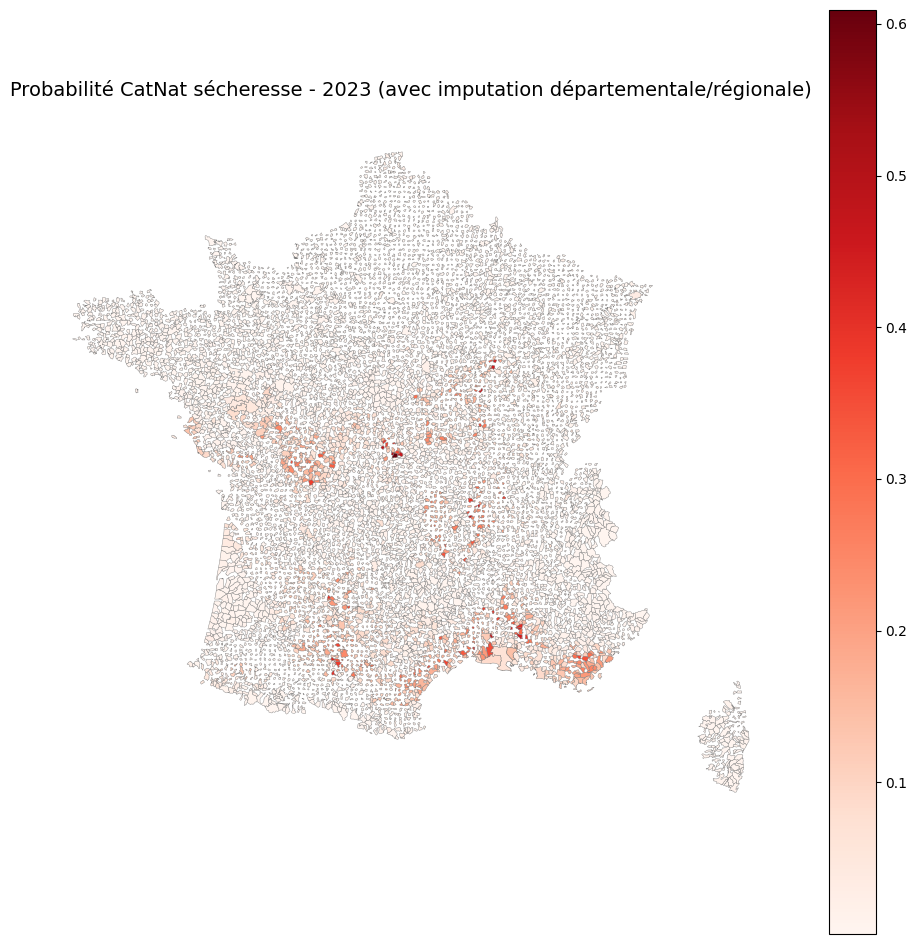

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_map_2023.plot(
    column='proba_secheresse_imputee',
    cmap='Reds',
    linewidth=0.3,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title("Probabilité CatNat sécheresse - 2023 (avec imputation départementale/régionale)", fontsize=14)
ax.axis('off')
plt.show()


In [25]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


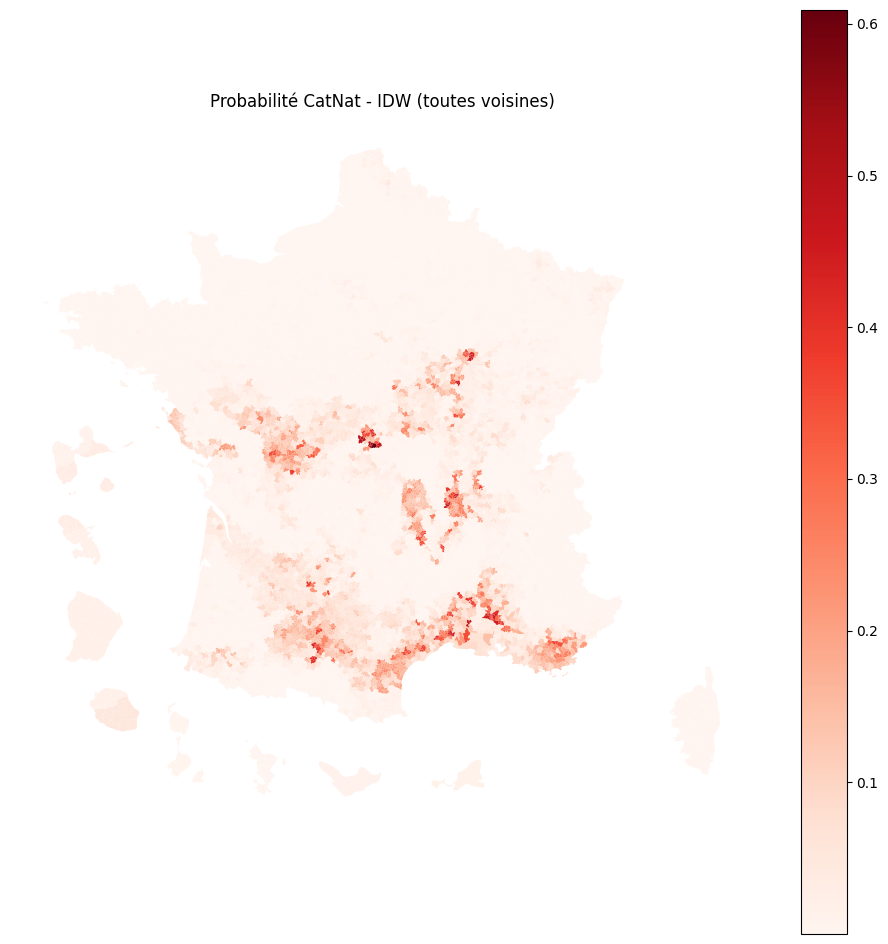

In [29]:
from scipy.interpolate import NearestNDInterpolator
import numpy as np

# 1. Centroïdes des communes connues
known_mask = gdf_map_2023['proba_secheresse'].notna()
centroids_known = gdf_map_2023.loc[known_mask, 'geometry'].centroid
coords_known = np.column_stack([centroids_known.x, centroids_known.y])
probas_known = gdf_map_2023.loc[known_mask, 'proba_secheresse'].values

# 2. Interpolateur (PAS de n_neighbors !)
interpolator = NearestNDInterpolator(coords_known, probas_known)

# 3. Centroïdes de TOUTES les communes
centroids_all = gdf_map_2023['geometry'].centroid
coords_all = np.column_stack([centroids_all.x, centroids_all.y])

# 4. Interpolation
gdf_map_2023['proba_secheresse_idw'] = interpolator(coords_all)

# 5. Carte
gdf_map_2023.plot(column='proba_secheresse_idw', cmap='Reds', legend=True, figsize=(12,12))
plt.title("Probabilité CatNat - IDW (toutes voisines)")
plt.axis('off')
plt.show()
